<h2 style="background-color:#697a89;color:white;padding:0px;line-height: 2em;">Noble Insurance Medical Claim Charges Analysis</h2>

<strong>Context</strong> - Leveraging customer information is of paramount importance for most businesses. In the case of an insurance company, the attributes of customers like the ones mentioned below can be crucial in making business decisions.

<strong>Objective</strong> – Statistical Analysis of Business Data.

* Prove (or disprove) that the medical claims made by the people who smoke is greater than those who don't.

* Prove (or disprove) with statistical evidence that the BMI of females is different from that of males.

* Is the proportion of smokers significantly different across different regions?

* Is the mean BMI of women with no children, one child, and two children the same? Explain your answer with statistical evidence.

*Consider a significance level of $\alpha$ = 0.05 for all tests.

<strong>Data Dictionary</strong>

* <b>Age</b> - This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government).
<br/><br/>
* <b>Sex</b> - This is the policy holder's gender, either male or female.
<br/><br/>
* <b>BMI</b> - This is the body mass index (BMI), which provides a sense of how over or underweight a person is relative to their height.BMI is equal to weight (in kilograms) divided by height (in meters) squared. An ideal BMI is within the range of 18.5 to 24.9.
<br/><br/>
* <b>Children</b> - This is an integer indicating the number of children/dependents covered by the insurance plan.
<br/><br/>
* <b>Smoker</b> - This is yes or no depending on whether the insured regularly smokes tobacco.
<br/><br/>
* <b>Region</b> - This is the beneficiary's place of residence in the U.S., divided into four geographic regions - northeast, southeast, southwest, or northwest.
<br/><br/>
* <b>Charges</b> - Individual medical costs billed to health insurance

<h3><a name="link_index">Table of Contents</a></h3> 
<ol>
<li><a href=#link_libs>Python Libraries Used</a></li>
    <ol>
        <li><a href=#link_udfs>Global variables, Constants and User Defined Functions</a></li>
    </ol>
<br>
<li><a href=#link_dataprep>Data Preparation</a></li>
<br>
<li><a href=#link_eda>EDA - Exploratory Data Analysis</a></li>
<ol>
<li><a href=#link_univariate>Univariate Analysis</a></li>
<li><a href=#link_multivariate>Multivariate Analysis</a></li>
    <ol>
        <li><a href=#link_multivariate_categorical>Categorical Variables Analysis</a></li>
        <li><a href=#link_multivariate_quantitative>Quantitative Variables Analysis</a></li>
    </ol>
</ol>
<br>
<li><a href=#link_hypothesis>Hypothesis Tests</a></li>
    <ol>
        <li>
            <a href=#link_hypothesis1>Are medical claims charges made by the people who smoke greater than those who don't ? </a>         </li>     
        <li>
            <a href=#link_hypothesis2>Is it possible to say with statistical evidence that the BMI of females is different from that of males ?</a>
        </li>
        <li>
            <a href=#link_hypothesis3>Is the proportion of smokers significantly different across regions ?</a>
        </li>
        <li>
            <a href=#link_hypothesis4>Is the mean BMI of women with no children, one child, and two children the same ?</a>
        </li>
    </ol>        
</ol>


<h3 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name="link_libs" href=#link_index>Python Libraries Used</a></h3>

In [1]:
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns

sns.set(style="darkgrid") # set stype for seaborn charts
palette = sns.color_palette("Paired")

#import statistics libraries
import scipy.stats as stats
from scipy.stats import skew
from statsmodels.stats.proportion import proportions_ztest #proportion ztest stats analysis

#warnings
import warnings
warnings.filterwarnings('ignore') #supress warnings

<h3 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name="link_udfs" href=#link_index>Global variables, Constants and User Defined Functions</a></h3>

In [2]:
###############################################################
# Global variables and constant literals used in this notebook
###############################################################
def constant(f):
    def fset(self, value):
        raise TypeError
    def fget(self):
        return f()
    return property(fget, fset)

class _Constant(object):
    @constant
    def vars_numeric_all():
        return ['age','bmi','children','charges']
    @constant
    def vars_category_all():
        return ['sex','smoker','region']
    @constant
    def significance_level():
        return 0.05
    
    #def add additional consts here   
    
const = _Constant();   

###############################################################
# Global user defined functions
###############################################################

# Function to enhance plots with percentage
def bar_plot_with_perc(plot, feature):
    total = len(feature) # length of the column
    for p in plot.patches:        
        x = p.get_x() + p.get_width() / 2 - 0.05 # width
        y = p.get_y() + p.get_height()           # height
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage for each slice of the category
        plot.annotate(percentage, (x, y), size = 12) # add the percentage label
    plt.show();

# Section Global functions def
def show_missing_data(df):
    total_nulls = df.isnull().sum().sort_values(ascending=False)   # total number of null values
    total_count = df.count()    
    percent = (total_nulls/total_count).sort_values(ascending=False)  # percentage of values that are null    
    missing_data = pd.concat([total_nulls,total_count,percent], axis=1, keys=['Total Nulls','Total Rows', '% Null'])  # putting the above two together
    return missing_data # return the dataframe

#Simple Histogram
def histogram_simple(feature,figsize=(12,8),title= None):
    
    if (title == None):
        title = "Univariate Analysis for "+ feature.name.upper()
               
    plt.figure(figsize = figsize);
    mean=feature.mean();
    median=feature.median();
    ax = sns.distplot(feature,
                      rug=True,                      
                      rug_kws={"color": "b"},
                      kde_kws={"color": "k", "lw": 1, "label": "KDE"},
                      hist_kws={"histtype": "step", "linewidth": 1,
                                "alpha": 1, "color": "b"}                  
                     )
    ax.set_title(title)
    ax.axvline(mean, color='green', linestyle='--',linewidth=2) # Add mean to the histogram
    ax.axvline(median, color='black', linestyle='-',linewidth=2) # Add median to the histogram

    plt.legend({'Mean':mean,'Median':median})
    plt.show();
    
# Histogram/Boxplot combo
def histogram_boxplot(feature, figsize=(12,8), bins = None):
    # Boxplot and histogram combined
    # feature: 1-d feature array    
    # figsize: size of fig default (12,8)
    # bins: number of bins (default None / auto)
    
    # While doing uni-variate analysis of numerical variables we want to study their central tendency 
    # and dispersion.This function takes the numerical column as the input and returns the boxplots 
    # and histograms for the variable.
    
    mean = feature.mean()
    median = feature.median()
    mode = feature.mode().tolist()[0]
                        
    f2, (ax_box2, ax_hist2) = plt.subplots( 
                                            nrows  = 2, # Number of rows of the subplot grid= 2
                                            ncols  = 1, #number of cols
                                            #sharex = True, # x-axis will be shared among all subplots
                                            gridspec_kw = {"height_ratios": (.25, .75)}, 
                                            figsize = figsize                                             
                                           ) # creating the 2 subplots
    
    f2.suptitle("Univariate Analysis for "+ feature.name.upper(),fontsize=16,fontweight='bold')    
    # Render box plot
    sns.boxplot(feature, ax=ax_box2, showmeans=True,orient='h', color='#F14848') # boxplot will be created and a star will indicate the mean value of the column
    ax_box2.set(xlabel='')
    
    # Render dist plot, for histogram 
    sns.distplot(feature,
                 kde=False,
                 label='kde',
                 color='#1A6BD7',
                 ax=ax_hist2,
                 bins=bins,
                 rug=True)\
    if bins\
       else sns.distplot(feature, 
                         kde=True,
                         label='kde',
                         color='#1A6BD7',
                         ax=ax_hist2,                          
                         rug=True,) 
    
    ax_hist2.axvline(mean,label='Mean',color='green', linestyle='--',linewidth=2) # Add mean to the histogram
    ax_hist2.axvline(median,label='Median',color='black', linestyle='-',linewidth=2) # Add median to the histogram    
    ax_hist2.axvline(mode,label='Mode',color='yellow', linestyle='dotted',linewidth=2) # Add mode to the histogram                    
    ax_hist2.legend()
    
    plt.show();
    
# determine the skewness in the variables
def skewed_features(data):
    #select_dtypes()- returns a subset of the dataframe based on the data types that are provided in the 'include' parameter.
    numerical_features=data[const.vars_numeric_all]    
    skewed_features = numerical_features.apply(lambda x : skew(x.dropna())).sort_values(ascending=False)
    return skewed_features;
    
# determine IQR in a dataframe series
def iqr(df, colname):    
    q_75, q_25 = np.percentile(df[colname], [75 ,25])
    return q_75-q_25; 


<h3 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name="link_dataprep" href=#link_index>Data Preparation</a></h3>

In [3]:
#read the dataset to be analysed
dataframe_ins = pd.read_csv('NobleInsurance.csv')
ins=dataframe_ins.copy() #keep the original df intact

In [4]:
# view a subset of the data top 5
ins.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# view a subset of the data bottom 5
ins.tail(5)

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [6]:
# Change the following variables to categorical variables
for col in ['sex', 'smoker', 'region']:
    ins[col] = ins[col].astype('category')

print(ins.dtypes)

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object


In [7]:
# shape of the data
print ('# rows:',ins.shape[0],' and # columns:',ins.shape[1])
print ('\n')
print('Number of unique values in each column:')
print(ins.nunique(axis=0))

# rows: 1338  and # columns: 7


Number of unique values in each column:
age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


In [8]:
# Check for missing data or null values
show_missing_data(ins)

,Total Nulls,Total Rows,% Null
charges,0,1338,0.0
region,0,1338,0.0
smoker,0,1338,0.0
children,0,1338,0.0
bmi,0,1338,0.0
sex,0,1338,0.0
age,0,1338,0.0


**Observation:**
- No null values have been found on the data.

<h2 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name='link_eda' href=#link_index>Exploratory Data Analysis</a></h2>

<h3 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name='link_univariate' href=#link_index>Univariate Data Analysis</a></h3>

In [9]:
# Describe the numerical variables, transposed for better visualization.
ins[const.vars_numeric_all].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [10]:
# Describe categorical variables.
ins[const.vars_category_all].describe().transpose()

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [11]:
# observations of each categorical variable
for i in range(len(const.vars_category_all)):
    print (ins[const.vars_category_all[i]].value_counts(),'\n')

male      676
female    662
Name: sex, dtype: int64 

no     1064
yes     274
Name: smoker, dtype: int64 

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64 



**Analysing Skewness**

In [12]:
skewed_features(ins)

charges     1.514180
children    0.937328
bmi         0.283729
age         0.055610
dtype: float64

* A skewness value of 0 in the output denotes a symmetrical distribution of values.
* A negative skewness value in the output indicates an asymmetry in the distribution. The tail of the plot islarger towards the left hand side of the distribution.
* A positive skewness value in the output indicates an asymmetry in the distribution. The tail of the plot is larger towards the right hand side of the distribution.

* **Charges** are positively skewed whereas **bmi and age** shows a low skewness level.


<h3 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name='link_univariate'>
    Analysing Central Tendency and Dispersion Shape of each individual numerical variables</a>
</h3>

**Age**

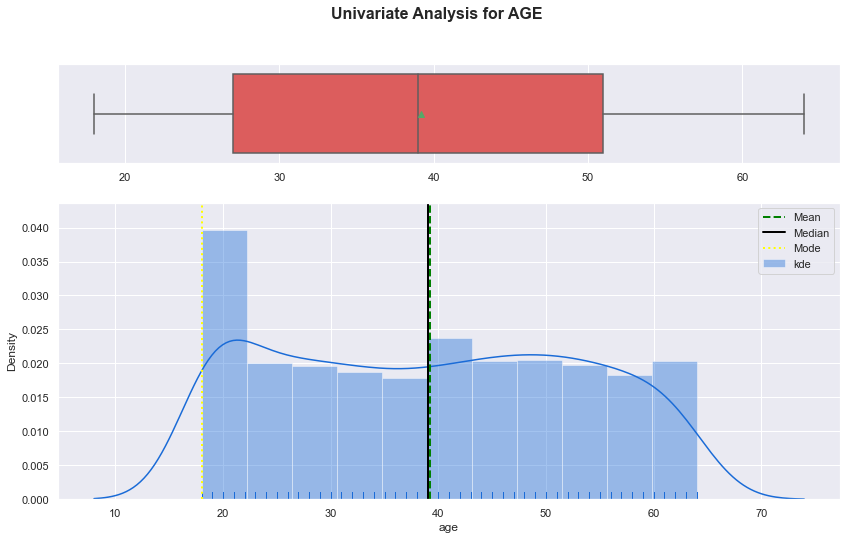

In [13]:
histogram_boxplot(ins.age,figsize=(14,8))

**Observations:**

- Age is shown to have an uniform distribution for the most part for ages past the mid 20's year range to mid 60's, with a sample mean of ~39 years of age.

**BMI**

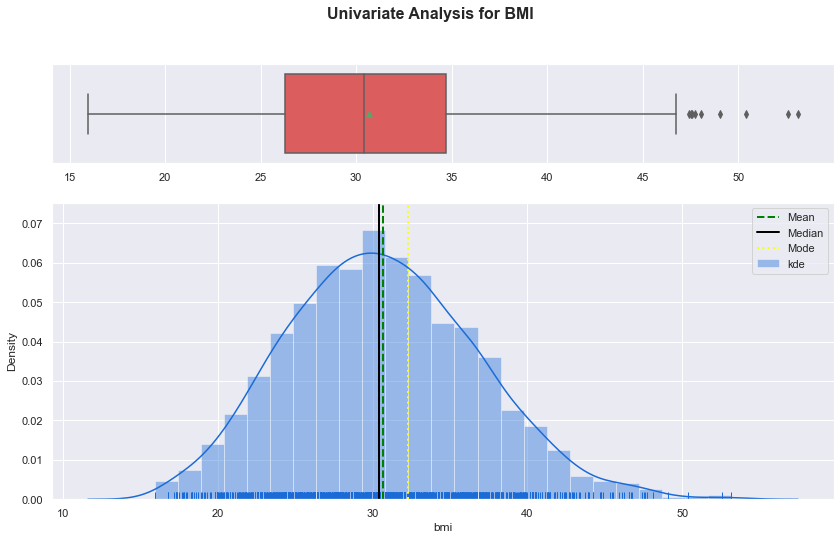

In [14]:
histogram_boxplot(ins.bmi,figsize=(14,8))

**Observations:**
- BMI is normally distributed.
- The sample mean BMI of insurers is <span style="color:red;font-weight: bold;">~ 30.5.</span> An ideal BMI is within the range of 18.5 to 24.9.

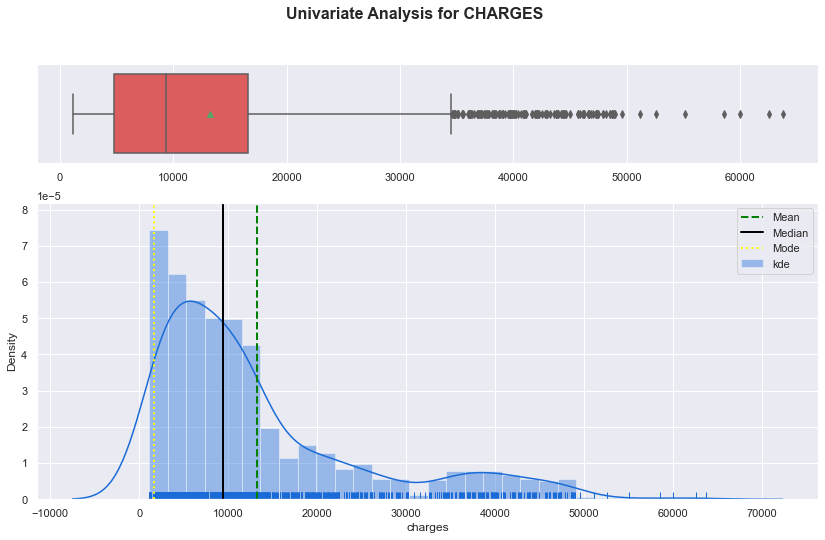

In [15]:
histogram_boxplot(ins.charges,figsize=(14,8))

**Observations:**
- Claim charges shows a high level of positive skewness with outliers above mid $35,000

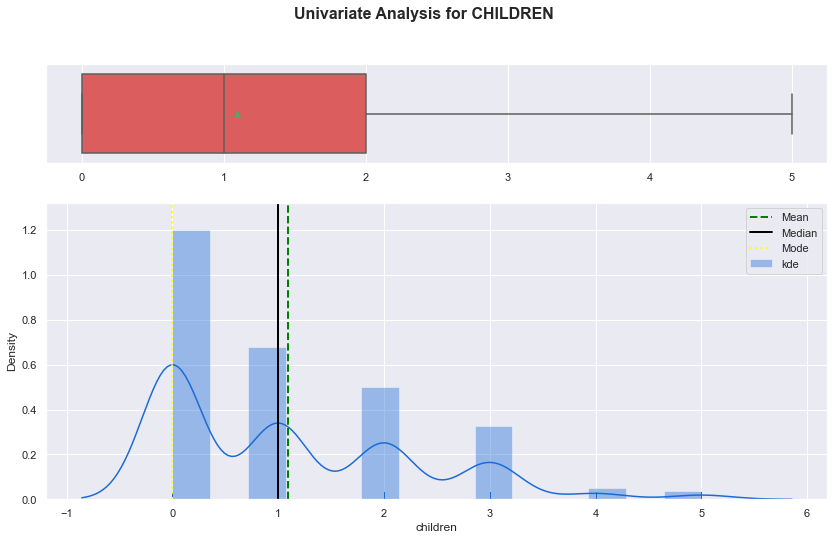

In [16]:
histogram_boxplot(ins.children,figsize=(14,8))

**Observations**
- Most insurers have less than 3 children.

<h2 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name='link_multivariate' href=#link_index>
    Multivariate Analysis</a>
</h2>

<h3 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name='link_multivariate_categorical' href=#link_index>
    Categorical Variables Analysis</a>
</h3>

**Smoker vs Non-Smoker**

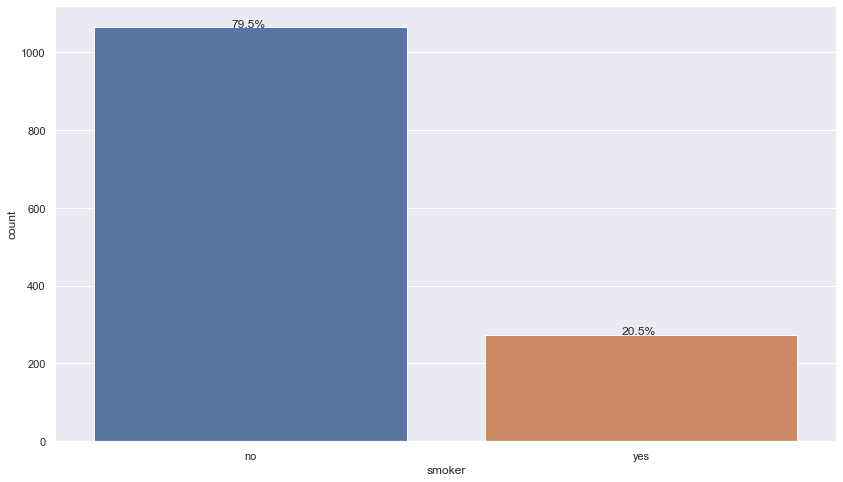

In [17]:
fig = plt.figure(figsize=(14,8))
plot= sns.countplot(x="smoker",data=ins)
bar_plot_with_perc(plot, ins.smoker)

**Observations:**
- The great majority of insurers are <span style="color:red;font-weight: bold;">non-smokers</span>

**Smoker vs Non-Smoker and Gender**

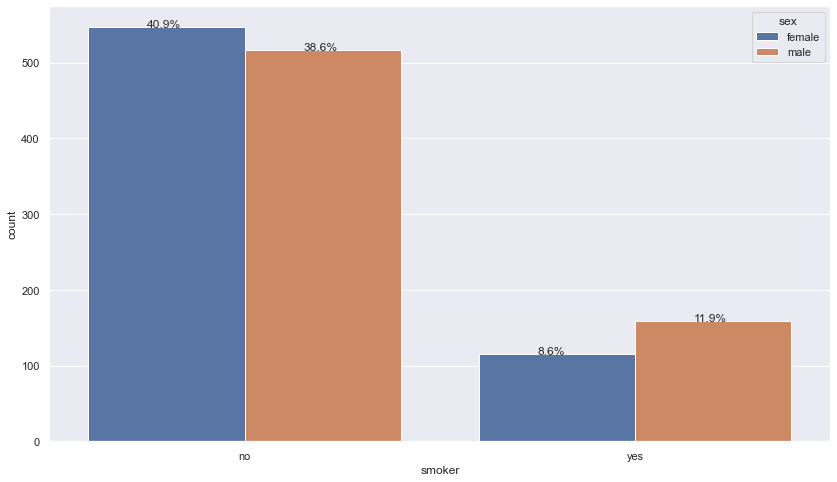

In [18]:
fig = plt.figure(figsize=(14,8))
plot= sns.countplot(x="smoker",data=ins,hue="sex")
bar_plot_with_perc(plot, ins.smoker)

**Observations:**

- **20.5% of the insurers are smokers**
- 11.9% of smokers are men
- 8.6%  of smokers are women.

- **79.5% of the insurers are non-smokers**
- 40.9% of non-smokers are women
- 38.6% of non-smokers are men.


**Region and smokers**

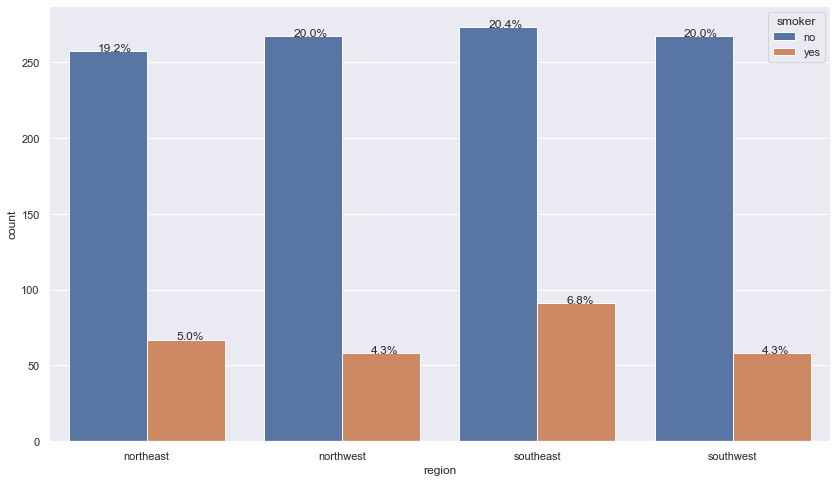

In [19]:
fig = plt.figure(figsize=(14,8))
plot= sns.countplot(x="region",data=ins,hue="smoker")
bar_plot_with_perc(plot, ins.smoker)

**Observations:**

- **The Southeast and the Northeast** have a <span style="color:red;font-weight: bold;">higher</span> prevalence of smokers than the Southwest and the Northwest.

**Region and BMI**

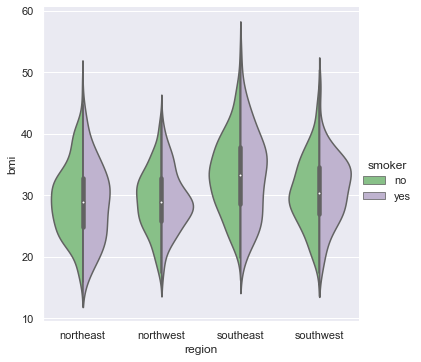

In [20]:
sns.catplot(
            x="region",y="bmi",
            data=ins,kind="violin",split=True,hue='smoker',
            palette=sns.color_palette("Accent"))

plt.show()


**Observations:**

- The Southeast region has higher prevalance of insurers with higher than ideal BMI level.

<h3 style="background-color:whitesmoke;padding:0px;line-height: 2em;"><a name='link_multivariate_quantitative' href=#link_index>
    Quantitative Variables Analysis</a>
</h3>

In [21]:
ins[const.vars_numeric_all].corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<AxesSubplot:>

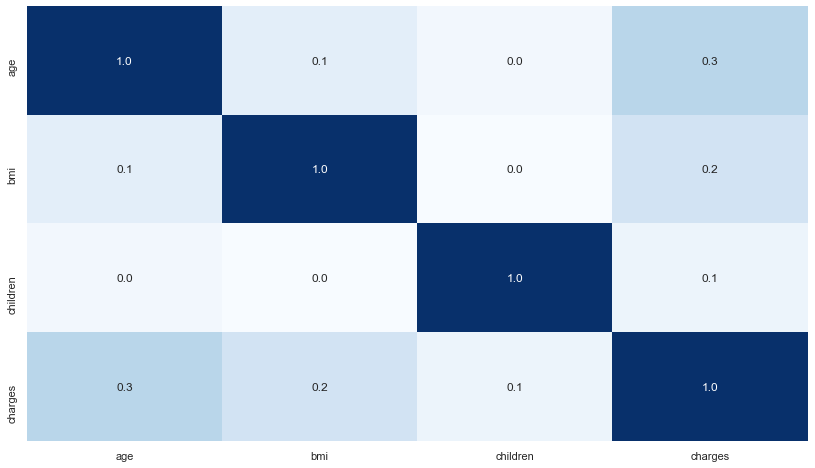

In [22]:
# plot the heatmap
plt.figure(figsize=(14,8))
ins_corr = ins[const.vars_numeric_all].corr()
sns.heatmap(data=ins_corr,
            annot=True,
            cmap='Blues',
            fmt=".1f",
            #fmt="d",
            xticklabels=ins_corr.columns,
            yticklabels=ins_corr.columns,
            cbar=False)

**Observations:**

- Age and charges are positively correlated.
- BMI and charges are positively correlated.
- Children and charges show some level of correlation.
- Age and BMI show some level of correlation.

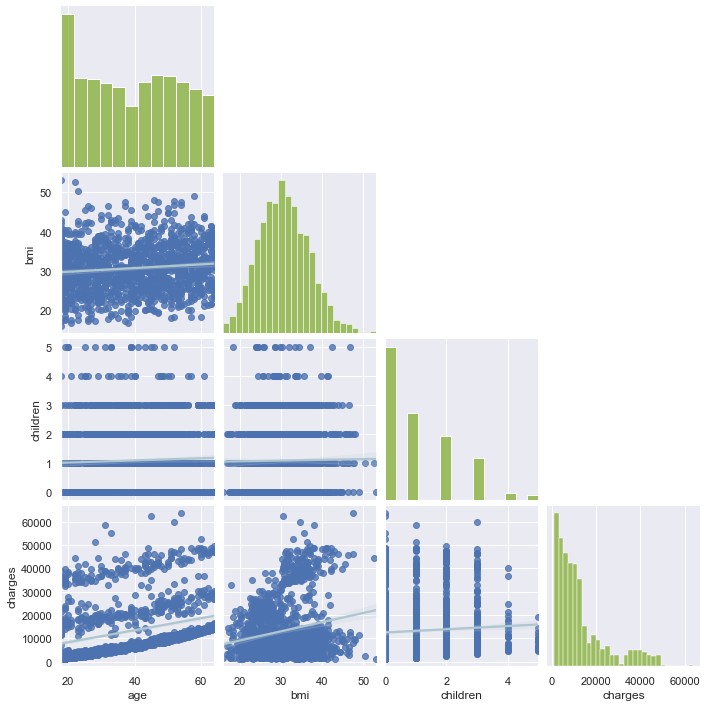

In [23]:
# Check for correlation among numerical variables
vars_numeric = const.vars_numeric_all

# plot the correlation
sns.pairplot(data=ins,
             vars=vars_numeric,
             diag_kind='auto', # vs. kde
             kind='reg',
             plot_kws={'line_kws':{'color':'#aec6cf'}},
                       #'scatter_kws': {'alpha': 0.5,color': '#82ad32'}},
                       corner=True,
             diag_kws= {'color': '#82ad32'})
plt.show();

**Observations:**

- Higher BMI results in higher charges.
- Higher Age results in higher charges.

**Smoker vs Charges**

<Figure size 1008x576 with 0 Axes>

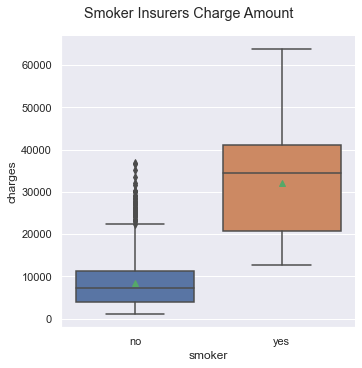

In [24]:
plt.figure(figsize=(14,8))
plot = sns.catplot(data=ins,x="smoker",y="charges",kind="box",showmeans=True)
plot.fig.subplots_adjust(top=0.9)
plot.fig.suptitle('Smoker Insurers Charge Amount')
plt.show()


**Observations:**
- There are less variance on non-smoker charges compared to smoker charges.
- Smoker chargers are higher than non-smoker charges.
- Observed outlier charges on the non-smoker category.

<Figure size 1008x576 with 0 Axes>

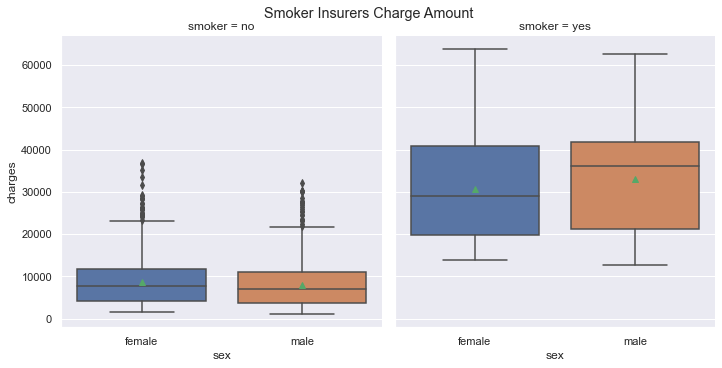

In [25]:
plt.figure(figsize=(14,8))
plot = sns.catplot(data=ins,x="sex",y="charges",kind="box",col="smoker",showmeans=True)
plot.fig.subplots_adjust(top=0.9)
plot.fig.suptitle('Smoker Insurers Charge Amount')
plt.show()

**Observations:**
- Males and Females non-smokers appear to have similar charge amount ranges, distributions and centers of tendency.
- Males and Females smokers have similar charge amount ranges and distributions.

<Figure size 1008x576 with 0 Axes>

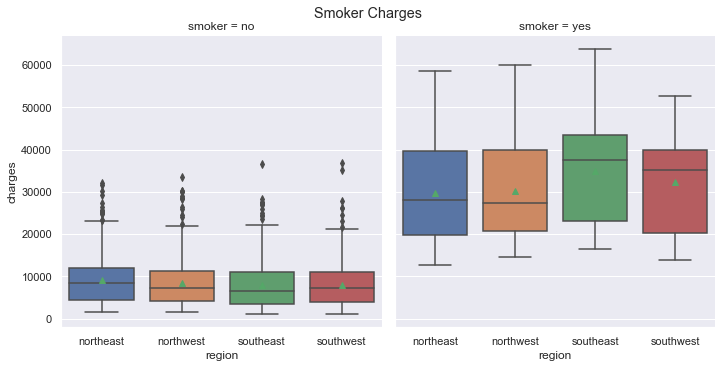

In [26]:
plt.figure(figsize=(14,8))
plot = sns.catplot(data=ins,x="region",y="charges",kind="box",col="smoker",showmeans=True)
plot.fig.subplots_adjust(top=0.9)
plot.fig.suptitle('Smoker Charges')
plt.show()

**Observations:**
- Smoker chargers are high in all the regions compared to non-smoker charges.
- The Southeast has a greater number of high charges compared to the other regions.

<Figure size 1008x576 with 0 Axes>

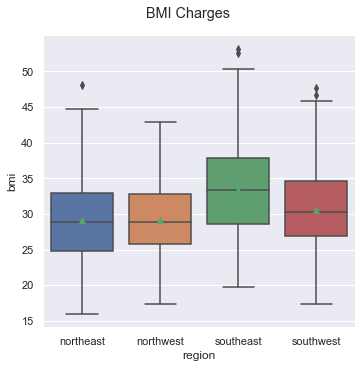

In [27]:
plt.figure(figsize=(14,8))
plot = sns.catplot(data=ins,x="region",y="bmi",kind="box",showmeans=True)
plot.fig.subplots_adjust(top=0.9)
plot.fig.suptitle('BMI Charges')
plt.show()

**Observations:**

- Insurers in the southeast region have higher BMI levels than the other regions.

<Figure size 1008x576 with 0 Axes>

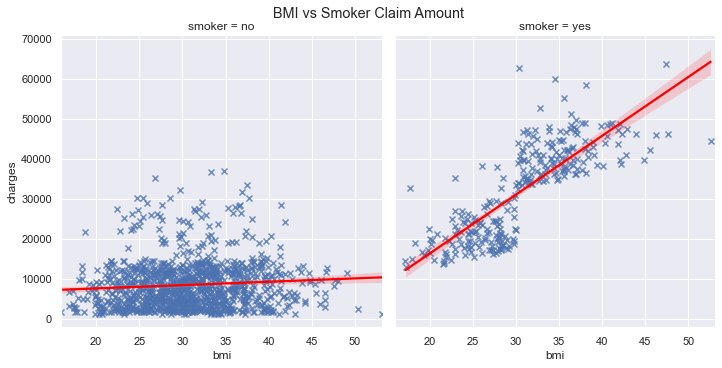

In [28]:
plt.figure(figsize=(14,8))
plot = sns.lmplot(data=ins, x="bmi", y="charges",col="smoker", markers='x',line_kws={'color': 'red'})
plot.fig.subplots_adjust(top=0.9)
plot.fig.suptitle('BMI vs Smoker Claim Amount')
plt.show()

**Observations:**
- As BMI for smoker insurers increases, medical charges increase.
- Observed only a modest increase in medical charges for non-smoker insurers.

<Figure size 1008x576 with 0 Axes>

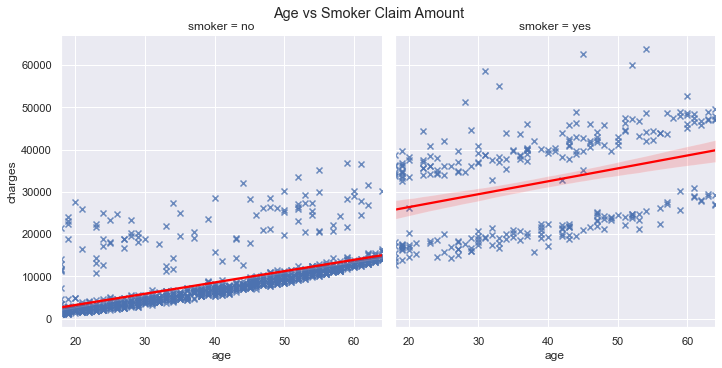

In [29]:
plt.figure(figsize=(14,8))
plot = sns.lmplot(data=ins, x="age", y="charges",col="smoker", markers='x',line_kws={'color': 'red'})
plot.fig.subplots_adjust(top=0.9)
plot.fig.suptitle('Age vs Smoker Claim Amount')
plt.show()

**Observations:**
- Medical charges for adults increase as they age, but medical costs are higher for those who smoke as observed above.

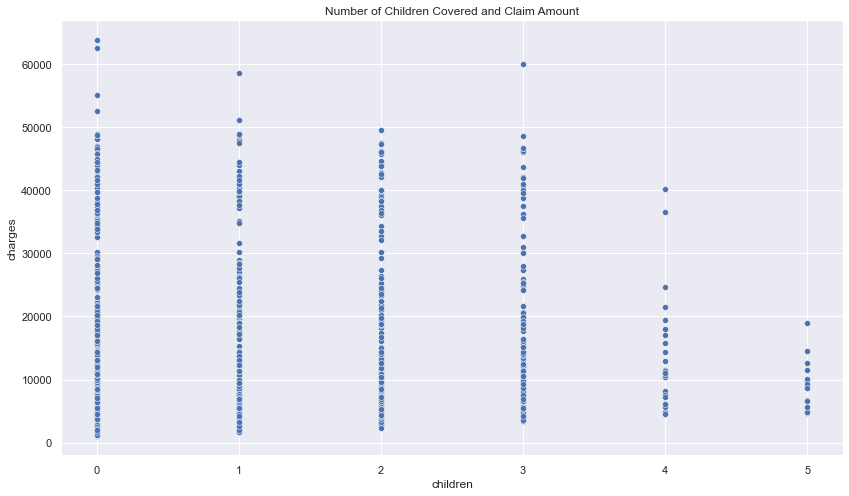

In [30]:
plt.figure(figsize=(14,8))
plot = sns.scatterplot(data=ins, x="children", y="charges")
ax = plt.gca()
ax.set_title("Number of Children Covered and Claim Amount")
plt.show()

**Observations**
- Insurers with 0,1,2 or 3 children appear to have similar medical costs.

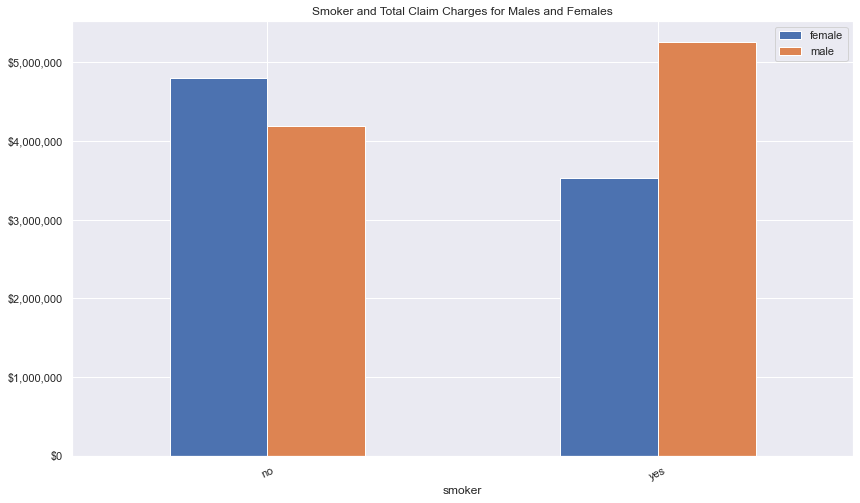

In [31]:
df1=pd.crosstab(index=ins.smoker,columns=ins.sex,values=ins.charges,aggfunc='sum')
fig1,ax1=plt.subplots(nrows=1,ncols=1,figsize=(14, 8))
df1.plot(kind='bar',ax=ax1,title="Smoker and Total Claim Charges for Males and Females")

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
plt.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

**Observations:**
- The total claim cost is higher for the insurers who smoke.
- The total claim cost for males smokers are higher than females smokers.
- The total claim cost for females non-smokers are higher than males non-smokers.

<h3 style="background-color:#85E3FE;padding:0px;line-height: 2em;"><a name='link_hypothesis' href=#link_index>
    Hypothesis Tests</a>
</h3>

<h3 style="background-color:#85E3FE;padding:0px;line-height: 2em;"><a name='link_hypothesis1' href=#link_index>
    1) Are medical claims charges made by the people who smoke greater than those who don't ?</a>
</h3>

Test the null hypothesesis

* H<sub>0</sub>: &mu;<sub>1</sub> = &mu;<sub>2</sub>, There is no difference between the claim charges of smokers vs non-smokers.

Against the alternative hypothesis

* H<sub>a</sub>: &mu;<sub>1</sub> &gt; &mu;<sub>2</sub>, Claim charges of people who smoke are higher than those who don't.

$\alpha$ = 0.05

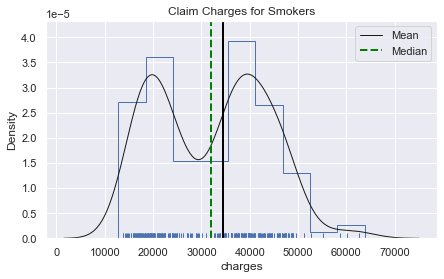

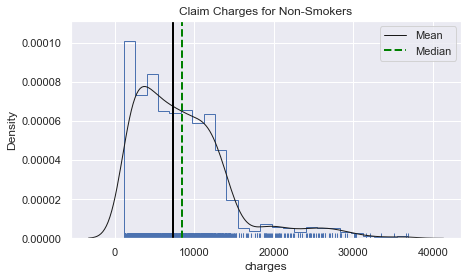

In [32]:
# 1) Creating two separate independent groups.
charges_s  = ins.charges[(ins.smoker=="yes")].sort_values(ascending=True)
charges_ns = ins.charges[(ins.smoker=="no")].sort_values(ascending=True)

# 2) Plotting to verify distributions of samples
histogram_simple(charges_s,figsize=(7, 4),title='Claim Charges for Smokers')
histogram_simple(charges_ns,figsize=(7, 4),title='Claim Charges for Non-Smokers')

# Not quite 100 % normal distribution, but observing the samples median and mean, there is a good level of normality for the t-test, given the sample size. 
# Charges distribution show positive skewness for non-smokers.

* Visualizing both distributions we can clearly see that the cost of charges for smokers differ from charges of non-smokers.

In [33]:
# 3) Finding the sample mean and sample standard deviations for both samples.

print ('The mean charge amount for smokers is:',round(charges_s.mean(),2))
print ('The mean charge amount for non-smokers is:',round(charges_ns.mean(),2))

print ('The standard deviation of charge amounts for smokers is:',round(charges_s.std(),2))
print ('The standard deviation of charge amounts for non-smokers is:',round(charges_ns.std(),2))

The mean charge amount for smokers is: 32050.23
The mean charge amount for non-smokers is: 8434.27
The standard deviation of charge amounts for smokers is: 11541.55
The standard deviation of charge amounts for non-smokers is: 5993.78


**Statistical evidence**

The standard deviation is not given, hence will use the T-Test to compare the sample means from these two independent populations.
 
**Test whether the T-test assumptions are satisfied**
- Continuous data. Yes, Charge Amount is a continuous variable.
- Normally distributed populations. 
    - Not quite 100% normality observed using the samples, but observing the median and mean, there is a 
      good level of normality for the t-test, given the sample size.
    - The populations are assumed normal.
- Unequal population deviations as observed on the samples.
    - The population deviations are assumed different.
    
- Random samples from the population. Yes, the collected samples are random.

**T-Test for equality of Means - One-Tailed Test - Unequal Std Dev**

In [34]:
# Calculate the T-test p_value with equal_var=False

test_stat,p_value = stats.ttest_ind(a=charges_s,
                                    b=charges_ns,
                                    equal_var=False,
                                    alternative='greater')

# test statistict and p_value outputs
print("tstats = ",test_stat, ", p_value = ", p_value)
print("\nConclusion:")

if p_value > const.significance_level:
    print("\nThere is no difference between the claim charges of smokers vs non-smokers. Accept the null hypothesis (H0).")
else:
    print ("\nThe p-value of %s is less than alpha(%.2f)\
 and it is statistically significant.It indicates strong evidence against the null hypothesis H0." %(p_value,const.significance_level))
    print("\nHence, claim charges for people who smoke are higher than those who don't.\
Reject the null hypothesis and accept the alternative hypothesis (Ha).")

tstats =  32.751887766341824 , p_value =  2.94473222335849e-103

Conclusion:

The p-value of 2.94473222335849e-103 is less than alpha(0.05) and it is statistically significant.It indicates strong evidence against the null hypothesis H0.

Hence, claim charges for people who smoke are higher than those who don't.Reject the null hypothesis and accept the alternative hypothesis (Ha).


**Conclusion:**
- Claim charges are higher for smoker than non-smokers.

<h3 style="background-color:#85E3FE;padding:0px;line-height: 2em;"><a name='link_hypothesis2' href=#link_index>
    2) Is it possible to say with statistical evidence that the BMI of females is different from that of males ?
</h3>

Test the null hypothesesis

* H<sub>0</sub>: &mu;<sub>1</sub> = &mu;<sub>2</sub>, The BMI of females is equal to BMI of males.(BMI is NOT affected by gender)

Against the alternative hypothesis

* H<sub>a</sub>: &mu;<sub>1</sub> &ne; &mu;<sub>2</sub>, The BMI of females is different than the BMI of males.(BMI is  affected by gender)

$\alpha$ = 0.05    

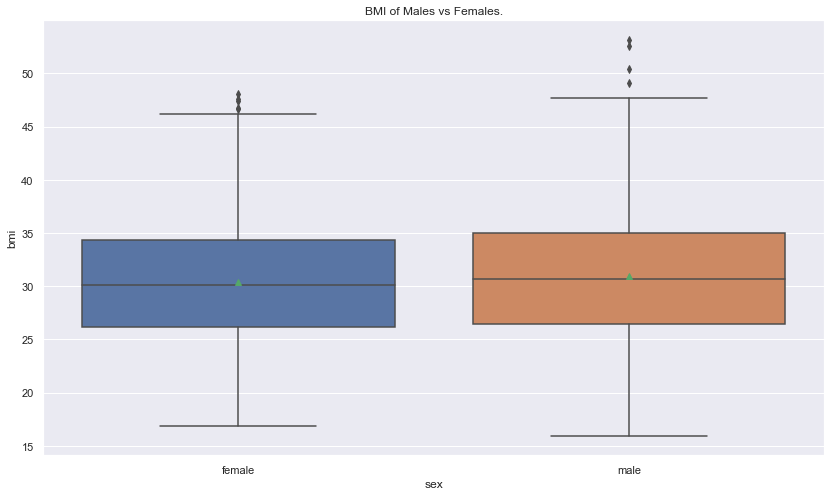

In [35]:
# plotting to verify variances between sample populations.
fix, ax = plt.subplots(figsize=(14,8))
a = sns.boxplot(x="sex",y="bmi",data=ins,showmeans=True)
a.set_title("BMI of Males vs Females.")
plt.show()

* Visual Analysis indicates that BMI distribution and measures of central tendency are similar for both males and females.

In [36]:
#Getting the BMI for males and females.
bmi_males=ins.bmi[ins.sex=="male"]
bmi_females=ins.bmi[ins.sex=="female"]

#Calculating the mean and std
print("Calculated mean of Male BMI:",round(bmi_males.mean(),2))
print("Calculated mean of Female BMI:",round(bmi_females.mean(),2))
print("Standard deviation of male BMI:",round(bmi_males.std(),2))
print("Standard deviation of female BMI:",round(bmi_females.std(),2))

Calculated mean of Male BMI: 30.94
Calculated mean of Female BMI: 30.38
Standard deviation of male BMI: 6.14
Standard deviation of female BMI: 6.05


**Statistical evidence**

The standard deviation is not given, hence will use the T-Test to compare the sample means from these two independent populations.
 
**Test whether the T-test assumptions are satisfied**
- Continuous data. Yes, Charge Amount is continuous variable.
- Normally distributed populations. 
    - Normality is observed using the samples.    
- Equal population deviations as observed on the samples.
    - The population deviations are assumed different.
- Random samples from the population. Yes, the collected samples are random.

**T-Test for equality of Means - Two-Tailed Test - Equal Std Dev**

In [37]:
# Calculate the T-test p_value with equal_var=True
t, p_value = stats.ttest_ind(a=bmi_males,
                             b=bmi_females,
                             equal_var=True,
                             alternative="two-sided")

print("\ntstats = ",t, ", p_value = ", p_value,'\n')
print("Conclusion:\n")

if p_value > const.significance_level:
    print ("The p-value of %.5f is higher than alpha(%.2f)\
 and is statistically non-significant(n.s.).\
 It indicates a strong evidence for the null hypothesis H0." %(p_value,const.significance_level))
    print("\nHence, BMI does NOT differ between genders. Failed to Reject the null hypothesis (H0).")
else:    
    print("BMI is different between genders. Accept the alternative hypothesis (Ha).")


tstats =  1.696752635752224 , p_value =  0.08997637178984934 

Conclusion:

The p-value of 0.08998 is higher than alpha(0.05) and is statistically non-significant(n.s.). It indicates a strong evidence for the null hypothesis H0.

Hence, BMI does NOT differ between genders. Failed to Reject the null hypothesis (H0).


**Conclusion:**
- BMI is not affected by the gender of the insurer.


<h3 style="background-color:#85E3FE;padding:0px;line-height: 2em;"><a name='link_hypothesis3' href=#link_index>
    3) Is the proportion of smokers significantly different across regions?
</h3>



Test the null hypothesesis:

* H<sub>0</sub> = The proportion of smokers are not significantly different across regions.

Against the alternative:

* H<sub>a</sub> = The proportion of smokers are significantly different across regions.

$\alpha$ = 0.05

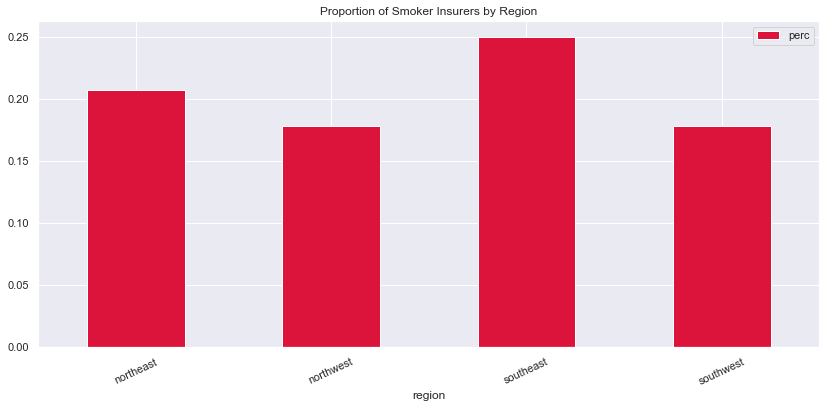

In [38]:
# Visual Analysis
contigency_table = pd.crosstab(ins['region'],ins['smoker'])
df1 = contigency_table.copy()
df1

df1.columns = df1.columns.add_categories('total')
df1.columns = df1.columns.add_categories('perc')
df1['total']=df1.sum(axis=1)
df1['perc']=df1['yes']/df1['total']
df1 = df1.filter(['region','perc'],axis=1)

fig1,ax1=plt.subplots(nrows=1,ncols=1,figsize=(14, 6))
df1.plot(kind='bar',ax=ax1,title="Proportion of Smoker Insurers by Region",color='#DC143C')

fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
plt.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [39]:
# Observed on the bar plot below ~17-25% of insurers are smokers across regions.

**Statistical evidence**

Using the chi-square with a contigency table to checks for homogeneity of the proportions.

**Contigency Table**

In [40]:
# Contigency Table = Frequency table of two variables presented side by side.
contigency_table

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


In [41]:
# Applying the chi2_contingency to test the hypothesis.

chi2_stat, p_value, dof, exp_freq = stats.chi2_contingency(contigency_table, correction=False)

print("\ntstats = ",chi2_stat, ", p_value = ", p_value,'\n')
print("Conclusion:\n")

if p_value > const.significance_level:
    print ("The p-value of %.5f is greater than alpha(%.2f)\
 and is statistically nonsignificant(n.s.). It indicates a strong evidence\nfor the null hypothesis H0." %(p_value,const.significance_level))
    print("\nHence, The proportion of smokers are NOT significantly different across regions. Failed to Reject the null hypothesis (H0).")
else:
    print ("The p-value of %.5f is less alpha(%.2f)\
 Hence,the proportion of smokers are significantly different across regions. Accept the alternative hypothesis (Ha).")


tstats =  7.343477761407071 , p_value =  0.06171954839170541 

Conclusion:

The p-value of 0.06172 is greater than alpha(0.05) and is statistically nonsignificant(n.s.). It indicates a strong evidence
for the null hypothesis H0.

Hence, The proportion of smokers are NOT significantly different across regions. Failed to Reject the null hypothesis (H0).


**Conclusion:**

- The proportion of smokers are not significantly different across regions.


<h3 style="background-color:#85E3FE;padding:0px;line-height: 2em;"><a name='link_hypothesis4' href=#link_index>
4) Is the mean BMI of women with no children, one child, and two children the same?
</h3>
    
ANOVA is used when we want to compare the means of a condition between more than two groups.

Let $\mu_1, \mu_2, \mu_3$ be the means of BMI for female with no children, one child and two children respectively.

We will test the null hypothesesis

>$H_0: \mu_1 = \mu_2 = \mu_3$. Women with zero, one, or two children show no difference in BMI levels.

Against the alternative hypothesis

>$H_a:$ At least one of these group has BMI mean different from the other groups.

In [42]:
#BMI dataframe for females with less or equal to two children.
dfBMI_F_LE_2_C = ins.loc[(ins.sex=="female") & (ins.children<=2)][['bmi','children']]
#BMI dataframe for females with no child 
dfBMI_F_0 = ins.loc[(ins.sex=="female" ) & (ins.children==0)][['bmi','children']]
#BMI dataframe for females with one child
dfBMI_F_1 = ins.loc[(ins.sex=="female" ) & (ins.children==1)][['bmi','children']]
#BMI dataframe BMI for females with two children
dfBMI_F_2 = ins.loc[(ins.sex=="female" ) & (ins.children==2)][['bmi','children']]

**ANOVA Test condition 1: Normality**

Appliying the Shapiro-Wilk's test
>$H_0:$ BMI follows a normal distribution

against

>$H_a:$ BMI does not follow a normal distribution

In [43]:
from scipy import stats
# find the p-value
w, p_value = stats.shapiro(dfBMI_F_LE_2_C) 
print('The p-value is', p_value)
# p_value is less than 0.05, reject h0, according to the test.

The p-value is 2.8951016759858767e-35


*Observation on Shapiro-Wilks's test for normality - Test did not return the expected result for normality of the distribution.*

Refer to this article below for explanation:
https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-3.php

"The one-way ANOVA is considered a robust test against the normality assumption. This means that it tolerates violations to its normality assumption rather well."

"There are two tests that you can run that are applicable when the assumption of homogeneity of variances has been violated: (1) Welch or (2) Brown and Forsythe test."

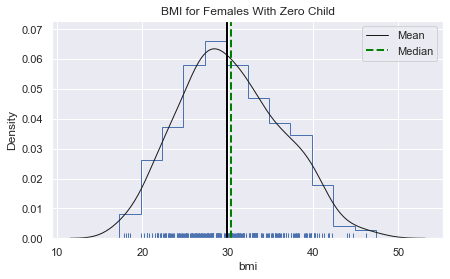

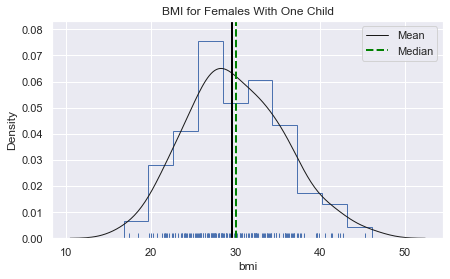

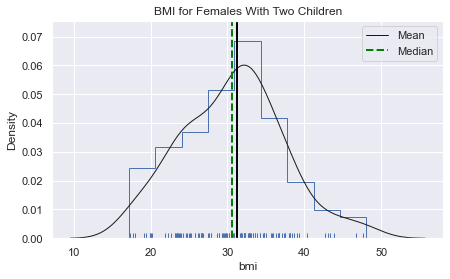

In [44]:
histogram_simple(dfBMI_F_0.bmi,figsize=(7, 4),title='BMI for Females With Zero Child')
histogram_simple(dfBMI_F_1.bmi,figsize=(7, 4),title='BMI for Females With One Child')
histogram_simple(dfBMI_F_2.bmi,figsize=(7, 4),title='BMI for Females With Two Children')  

**Observations on Normality:**
- All 3 groups resemble a normal distributions. Passed the test on normality.


**ANOVA Test condition 2: Variance - Leneve's Test**

Appliying the Leneve test
>$H_0:$ BMI variances are equal among all female with 0,1,2 children.

against

>$H_a:$ There is at least one variance different with the rest of the group.

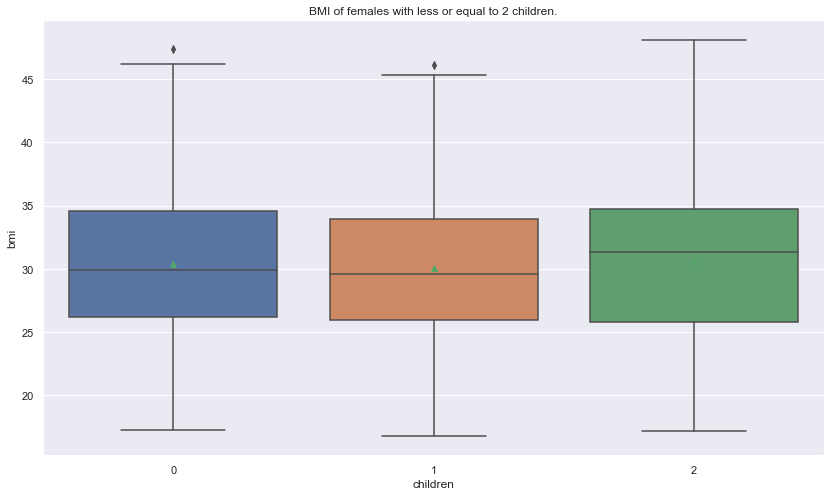

IQR of BMI for females with no child:  8.4
IQR of BMI for females with one child:  7.96
IQR of BMI for females with two children:  8.98


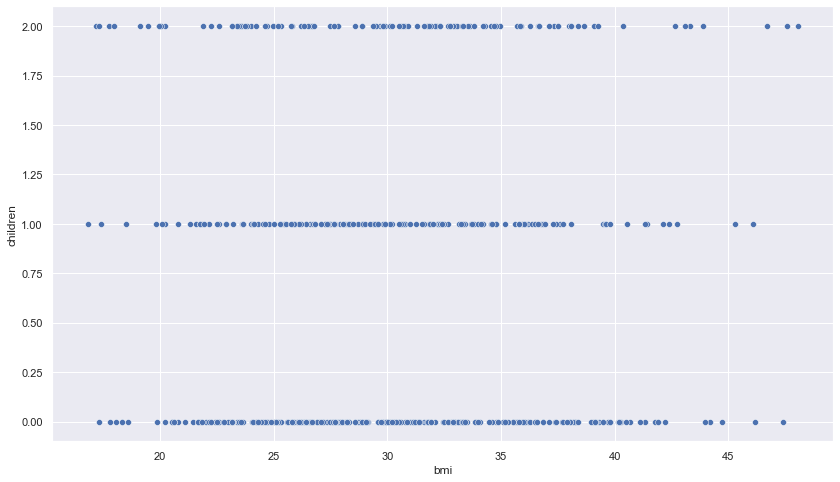

In [45]:
# plotting to verify variances between sample populations.
fix, ax = plt.subplots(figsize=(14,8))
a = sns.boxplot(x="children",y="bmi",data=dfBMI_F_LE_2_C,showmeans=True)
a.set_title("BMI of females with less or equal to 2 children.")
plt.show()

#Checking for variances between groups. A condition for the ANOVA test
#Interquartile range will tell how close these groups are.
print ("IQR of BMI for females with no child: ",round(iqr(dfBMI_F_0,'bmi'),3))
print ("IQR of BMI for females with one child: ",round(iqr(dfBMI_F_1,'bmi'),3))
print ("IQR of BMI for females with two children: ",round(iqr(dfBMI_F_2,'bmi'),3))

plt.figure(figsize=(14,8))
df2 = ins.loc[(ins.sex=="female" ) & (ins.children<=2)][['bmi','children']]
plot = sns.scatterplot(data=df2, x="bmi", y="children", markers='o')
plt.show()


**Conclusion:**
- Observed small IQR variances between groups.
- Observed visually analysing the boxplot and scatterplots the same.

In [46]:
## Applying Leneve's test for validation of variance condition.

from scipy.stats import levene

statistic, p_value =levene(
                            dfBMI_F_0['bmi'],
                            dfBMI_F_1['bmi'],
                            dfBMI_F_2['bmi']
                          )

print("\nstatistic = ",statistic, ", p_value = ", p_value,'\n')

print("Conclusion:\n")
if p_value > const.significance_level:
    print("BMI variances are equal (H0).")
else:    
    print("BMI variances are not equal (H1).")   


statistic =  0.9433311607108589 , p_value =  0.3899432394522804 

Conclusion:

BMI variances are equal (H0).


**Statistical evidence**

Using ANOVA one-way test.

ANOVA is used for three or more groups of data, to gain information about the relationship of variables.

**Applying ANOVA one-way test.**

 ANOVA is used for three or more groups of data to find statistical differences among the means of the groups.
 
 **Test whether the T-test assumptions are satisfied**
- Normally distributed populations: Passed. Verified visually.
- Variances are equal: Passed. Verified both visually and using Levene's test.
- Random independent samples: Passed.

In [47]:
# Performing an one-way ANOVA test.
from scipy.stats import f_oneway
statistic,p_value = f_oneway(dfBMI_F_0['bmi'],
                             dfBMI_F_1['bmi'],
                             dfBMI_F_2['bmi'])

print("\nstatistic = ",statistic, ", p_value = ", p_value,'\n')

print("Conclusion:\n")

if p_value > const.significance_level:
    print ("The p-value of %.5f is greater than alpha(%.2f)\n\n\
BMI levels are similar among women with zero, one or two children. Failed to reject the null hypothesis (H0)." %(p_value,const.significance_level))     
else:
    print ("The p-value of %.5f is greater than alpha(%.2f)\
BMI level is different among women with zero, one or two children.\Accepting alternative hypothesis (H1)." %(p_value,const.significance_level)) 
    



statistic =  0.3344720147757968 , p_value =  0.7158579926754841 

Conclusion:

The p-value of 0.71586 is greater than alpha(0.05)

BMI levels are similar among women with zero, one or two children. Failed to reject the null hypothesis (H0).


**Conclusion:**
- We cannot conclude that a significant difference in BMI exists among women with zero, one or two children.